<a href="https://colab.research.google.com/github/duyvm/funny_stuff_with_llm/blob/main/learning-rag/Langchain_Rag_Guide_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

- Install required packages
- Set environment variables
- Load model and vector db

In [1]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph langchain[openai] langchain-core beautifulsoup4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.1/438.1 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.0/363.0 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 10.4 MB/s eta 0:00:00


In [2]:
from google.colab import userdata
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_PROJECT"] = f"langchain-learning-rag"
os.environ["LANGSMITH_API_KEY"] = userdata.get('LANGSMITH_API_KEY')
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

# Preview

- Guide: [Build a Retrieval Augmented Generation (RAG) App: Part 2](https://python.langchain.com/docs/tutorials/qa_chat_history/)

- Extend application capabilities beyond document retrieval:

  - Add `memory` of past questions and answers

  - Incorporating this `memory` into thinkings for accuracy retrieved results

  - Add `query analysis` (missing in part 1)


- Follow the tutorial, two approaches:

  - Chains (or AI worflow): application execute at most one retrieval step each query

  - Agents: give the application discretion to execute multiple retrieval steps for finding the optimal answer

In [3]:
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore

llm = init_chat_model("gpt-4o-mini", model_provider="openai")
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
vector_store = InMemoryVectorStore(embeddings)

## Chains approach

- Application execute at most one retrieval step each query

In [7]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph, MessagesState
from typing_extensions import List, TypedDict

# load and chunk the content of the blog
blog_url = "https://lilianweng.github.io/posts/2023-06-23-agent/"

loader = WebBaseLoader(
    web_paths=(blog_url,),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    )
)

docs = loader.load()

In [5]:
# split the documents
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

In [6]:
# index chunk and store in db
_ = vector_store.add_documents(all_splits)

### Tool-calling for retrieval step

- Instead of passing the whole user's question as query for searching relevant documents, we can leverage tool-calling for the retrieval step. With this approach, our query will be generated by the model. It is not only extract information from current user's question, but also gather information based on chat history for contextualization.

- This is important in a conversational setting.

- This allows the model to rewrite our queries into more effective search queries.

- Furthermore, leveraging model in retrieval step can support direct reponse that is not involve a retrieval step

In [25]:
from langchain_core.tools import tool

# wrap our retrieve function with tool
@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """
    Retrieve information related to input query
    """
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

### Prepare function for Graph's Node

Graph consists of three nodes:

1. A node that receive user input, either responding directly or generating a query for next node

2. A node for retriever tool that execute retrieval step

3. A node that generates final response using retrieved information

The output from a step is wrap to `ToolMessage`

In [48]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode

# 1st step
def query_or_response(state: MessagesState):
    """
    Generatate query for retrieval or response directly to user
    """
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState will appends messages to state after each note execution
    return {"messages": [response]}

# 2nd step: retrieval
tools = ToolNode([retrieve])

# 3rd step: generate response to user's question based on retrieved context
def generate(state: MessagesState):
    """
    Generate response
    """
    # get the most recent tool messages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break

    # revese its order
    tool_messages = recent_tool_messages[::-1]

    # format into prompt
    doc_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, just say that you "
        "don't know, don't try to make up an answer. Use three sentences "
        "maximum and keep the answer concise. "
        "\n\n"
        f"{doc_content}"
    )

    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]

    prompt = [SystemMessage(content=system_message)] + conversation_messages
    response = llm.invoke(prompt)
    return {"messages": [response]}

### Build the Graph

Build the graph by connecting all the steps into sequences and compile it

In [50]:
from langgraph.graph import END
from langgraph.prebuilt import tools_condition

graph_builder = StateGraph(MessagesState)

graph_builder.add_node(query_or_response)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point(query_or_response.__name__)
graph_builder.add_conditional_edges(
    query_or_response.__name__,
    tools_condition,
    { END: END, tools.name: tools.name },
)

graph_builder.add_edge(tools.name, generate.__name__)
graph_builder.add_edge(generate.__name__, END)

graph = graph_builder.compile()

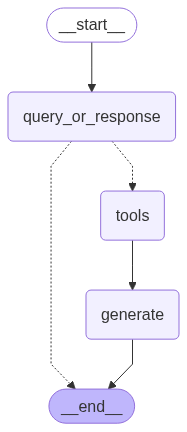

In [45]:
# visualize the graph
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [46]:
# testing with greeting message, not query
for step in graph.stream(
    {"messages": [{"role": "user", "content": "Otsukareisama desu"}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Otsukareisama desu
================================== Ai Message ==================================

Otsukareisama desu (お疲れ様です) is a Japanese expression used to acknowledge someone's hard work or effort. It can be translated to "Thank you for your hard work" or "Good job." It's commonly used in the workplace or after completing a task to show appreciation and respect. If you have any specific questions or need further information related to this phrase, feel free to ask!


In [51]:
# ask about the content
for step in graph.stream(
    {"messages": [{"role": "user", "content": "What is Task Decomposition?"}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_YltyPJ9e2zJ7oj35vlhu8dhV)
 Call ID: call_YltyPJ9e2zJ7oj35vlhu8dhV
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to des

In [52]:
# follow up question, no chat history
for step in graph.stream(
    {"messages": [{"role": "user", "content": "Can you look up some common ways of doing it?"}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up some common ways of doing it?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_6ba1jv83ADZsNZOJ5Cq2XFVC)
 Call ID: call_6ba1jv83ADZsNZOJ5Cq2XFVC
  Args:
    query: common ways of doing it
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an interm

### With memory of history chat

- Using in-memory

In [57]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

config = {"configurable": {"thread_id": "duyvm456"}}

In [58]:
# re-ask the questions
for step in graph.stream(
    {"messages": [{"role": "user", "content": "What is Task Decomposition?"}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_HarJbXJLD0vOdhxrmJFwC2ak)
 Call ID: call_HarJbXJLD0vOdhxrmJFwC2ak
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to des

In [59]:
for step in graph.stream(
    {"messages": [{"role": "user", "content": "Can you look up some common ways of doing it?"}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up some common ways of doing it?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_4ULyFBC8mCVEuN5v2f4qPlgy)
 Call ID: call_4ULyFBC8mCVEuN5v2f4qPlgy
  Args:
    query: common methods of task decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL)

## Agent approach

- Leverage reasoning capabilites of LLMs to make decisions during execution

- No need for fixed path

- Offload the discretion over the retrieval process

In [60]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)

Instead of calling on the fixing path til final `generate` step at the end of the run. Here the agent continue calling the tools to retreive more information until it decides to answer the question

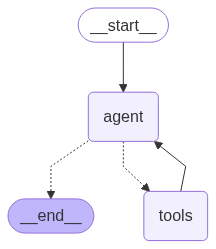

In [61]:
display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [62]:
config = {"configurable": {"thread_id": "agent123"}}

input_message = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method"
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_MSOPWVP3bl9BUHzQiOAIxNJL)
 Call ID: call_MSOPWVP3bl9BUHzQiOAIxNJL
  Args:
    query: standard method for Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon plan